In [2]:
suppressMessages(library("EnsDb.Hsapiens.v86"))
suppressMessages(library(scater))
suppressMessages(library(tidyverse))
library(beachmat)

In [3]:
source("../BSSI_scRNAseq//pipeline_class_042420.R")

In [4]:
opt = list(in_dir = "/home/jgagnon1/jupyter-notebook-dir", gene_info_file = "MS_Nature_gene_info.csv", 
          meta_file = "MS_Nature_meta_data.csv", sampleID_var = "sample", cluster_var = "cell_type",
          cluster = "Microglia", group_var = "diagnosis", reference_group = "Control", alternative_group = "MS", 
          count_file = "MS_Nature_UMI_subset.mtx", covars = "Capbatch,age,sex", 
          out_dir =  "/home/jgagnon1/scRNAseq/", 
          out_prefix = "MS_Nature",glmm_model="nbinom2")

if (is.na(opt$covars)) {
  covars = NULL 
} else {
  covars = unlist(strsplit(opt$covars, split = "[ ,;]+"))
}

UMI_data<-readMM(file.path(opt$in_dir, opt$count_file))
meta_info=read.csv(file.path(opt$in_dir, opt$meta_file), stringsAsFactors=FALSE)
gene_info=read.csv(file.path(opt$in_dir, opt$gene_info_file), stringsAsFactors=FALSE)
meta_info<-meta_info%>%dplyr:::mutate(cell_type= case_when(cell_type=="OL-C"|cell_type=="OL-B"|cell_type=="OL-A"~"OL",
                                                           cell_type=="EN-L2-3-A"|cell_type=="EN-L2-3-B"~"EN-L2-3",
                                                           TRUE~cell_type))
meta_info$cell_type <- gsub(" ", "_", meta_info$cell_type)
meta_info<-meta_info%>%dplyr:::mutate(stage= case_when(stage=="Acute/Chronic active"~"Active",
                                                       stage=="Chronic inactive"~"Inactive",
                                                       TRUE~"Control"))
count_data <- t(UMI_data)
colnames(count_data)<-meta_info$cell
rownames(count_data) <- gene_info$index

# load the data
sce <- BiostatsSingleCell$new(count_data = count_data,
                              meta_data = meta_info,
                              sampleId_col = opt$sampleID_var,
                              cluster_col = opt$cluster_var,
                              treatment_col = opt$group_var)


Dimensions of counts data: 
[1] 33525 44992

Cluster summary...
      Astrocytes B_cells Endo_cells EN-L2-3 EN-L4 EN-L5-6 EN-MIX EN-PYR Glia-MIX IN-PVALB IN-SST IN-SV2C IN-VIP Microglia   OL  OPC Phagocytes Stromal_cells T_cells
                                                                                                                                                                    
C1           265       0          1     276   118     116    141      2       65       78     32      26    116        75  445  151         15             3       0
C2            37       0          0     179   134     113    259      2      120       53     58      22     90         1  114   63          2             0       0
C3           356       0          0     473   185     168    131      5       67      132     70      60    159         8  821  246          3             2       1
C4           291       0          0     556   301     179     60      6       23      108     73      44    201

In [5]:
# Make QC plots
#sce$make_QCplots(file.path(opt$out_dir, "UMI_diagnosis_QC_plot_jupyter.pdf"))


png 
  2

In [6]:
# 1st round of filtering
sce$apply_filter(min.perc.cells.per.gene = 0.00) # 0% expression requirement

# set mode
sce$set_group_mode(cluster_of_interest = opt$cluster, ref_group = opt$reference_group, alt_group = opt$alternative_group)

# Filtering round 2
sce_qc <- sce$apply_filter_contrasts_R6()


Dimensions of scRNAseq counts data after filtering...
[1] 33525 44990

Cluster summary...
      Astrocytes B_cells Endo_cells EN-L2-3 EN-L4 EN-L5-6 EN-MIX EN-PYR Glia-MIX IN-PVALB IN-SST IN-SV2C IN-VIP Microglia   OL  OPC Phagocytes Stromal_cells T_cells
                                                                                                                                                                    
C1           265       0          1     276   118     116    141      2       65       78     32      26    116        75  445  151         15             3       0
C2            37       0          0     179   134     113    259      2      120       53     58      22     90         1  114   63          2             0       0
C3           356       0          0     473   185     168    131      5       67      132     70      60    159         8  821  246          3             2       1
C4           291       0          0     556   301     179     60      6       23     

Minimum cells per gene was set to 50


Summary after filtering...
Dimensions of counts data: 
[1]   74 1425

Cluster summary...
      Microglia
               
C1           75
C2            1
C3            8
C4            3
C5           47
C6            1
C7            1
MS1         210
MS10        111
MS11         25
MS12         73
MS2          60
MS3          93
MS4         304
MS5          44
MS6          33
MS7         262
MS8          26
MS9          48

Mitochondrial genes found: 
character(0)

Dimensions of pseudo-bulk counts data: 
[1] 74 19


In [7]:
cluster = opt$cluster
prefix = opt$out_prefix

ID,log2FC,Pvalue,FDR
SLC1A3,0.5644356,0.009417219,0.5841872
NAV3,-1.0555146,0.015788843,0.5841872
ST6GALNAC3,-1.2899164,0.081670693,0.5889352
SRGAP2B,-0.2855347,0.146732505,0.5889352
SLC8A1,-0.4797311,0.058154435,0.5889352
FYB1,0.8747559,0.101056854,0.5889352


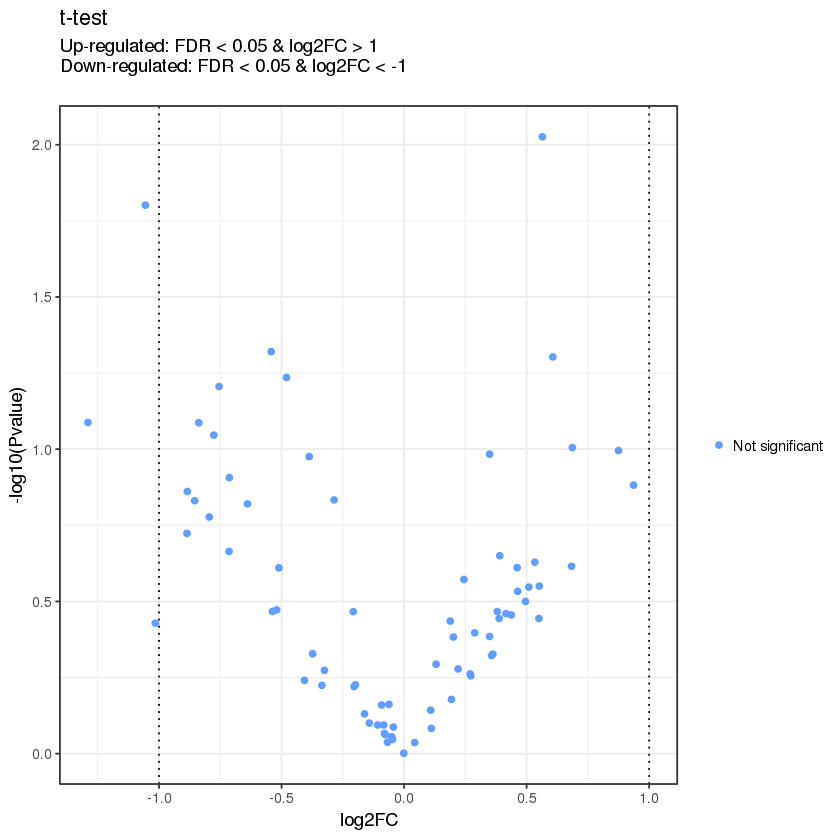

In [8]:
t.test.res <- sce_qc$t_test_pipeline()
head(t.test.res)
sce_qc$volcanoPlot(FDR_threshold = 0.05, FC_threshold = 2, title = "t-test")

Warning message in wilcox.test.default(x[treated_index], x[placebo_index]):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(x[treated_index], x[placebo_index]):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(x[treated_index], x[placebo_index]):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(x[treated_index], x[placebo_index]):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(x[treated_index], x[placebo_index]):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(x[treated_index], x[placebo_index]):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(x[treated_index], x[placebo_index]):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(x[treated_index], x[placebo_index]):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(x[treated_index], x[placebo_index

ID,log2FC,Pvalue,FDR
ST6GALNAC3,-1.2899164,0.04493133,0.3022653
SLC8A1,-0.4797311,0.04493133,0.3022653
SLC1A3,0.5644356,0.00976423,0.3022653
TBXAS1,-0.5423434,0.01297928,0.3022653
ADAM28,-0.7764119,0.02834008,0.3022653
OXR1,-0.7133917,0.04493133,0.3022653


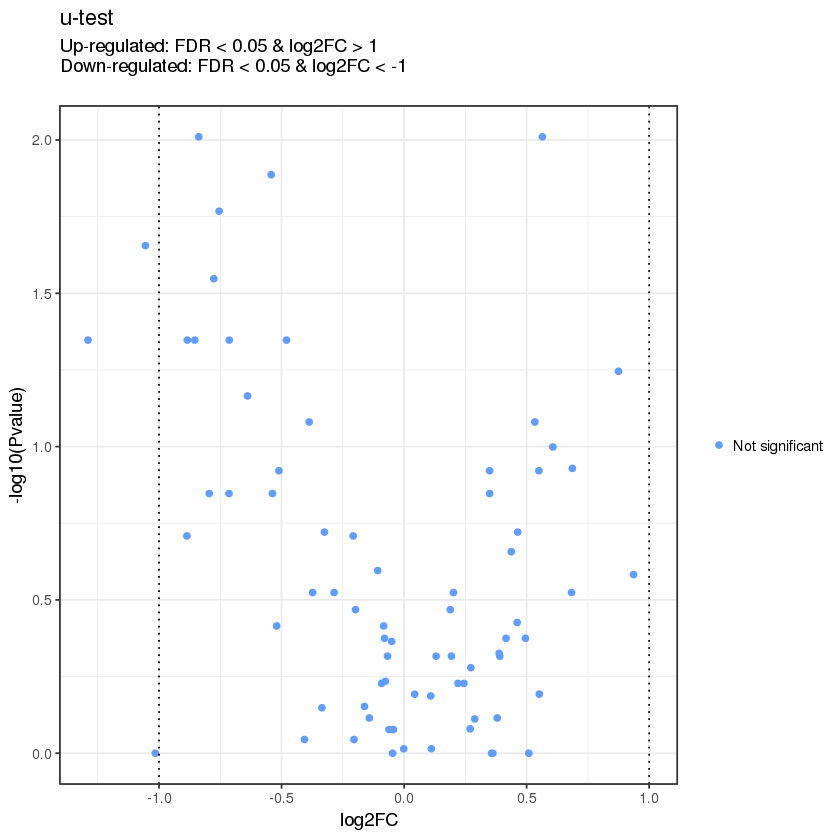

In [9]:
u.test.res <- sce_qc$u_test_pipeline()
head(u.test.res)
sce_qc$volcanoPlot(FDR_threshold = 0.05, FC_threshold = 2, title = "u-test")

Joining, by = "sample"


Forming DGEList...
Calculating NormFactors...
Creating design matrix...
Estimating dispersions...
Fitting the model...
Running QLFTest...


ID,log2FC,logCPM,F,Pvalue,FDR
SLC1A3,1.6172196,14.08005,17.194781,0.0006588246,0.04875302
ST6GALNAC3,-1.9417030,12.46495,12.352475,0.0026158604,0.08736771
ARHGAP24,0.9953172,14.18003,10.050219,0.0055261385,0.08736771
ARHGAP26,1.2159490,13.32496,9.998731,0.0056240161,0.08736771
MALAT1,1.5494192,18.00301,9.857229,0.0059032237,0.08736771
NAV3,-1.0901139,13.41088,7.395715,0.0144510931,0.17823015


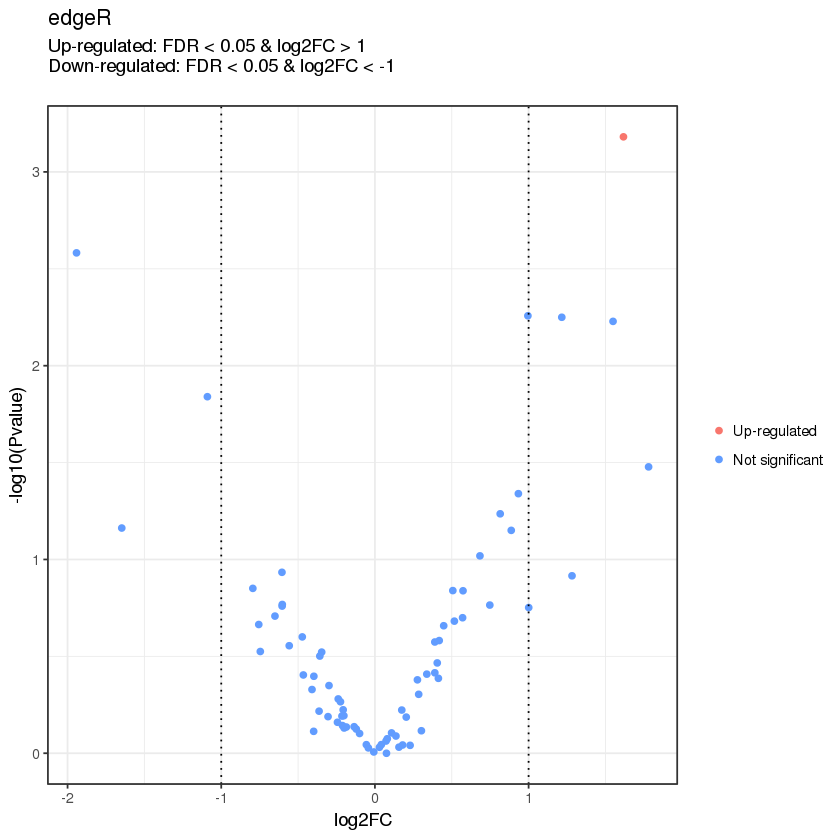

In [10]:
edgeR.res <- sce_qc$edgeR_pipeline(covs = covars)#, covs_formula = opt$covars_formula)
head(edgeR.res)
sce_qc$volcanoPlot(FDR_threshold = 0.05, FC_threshold = 2, title = "edgeR")

Joining, by = "sample"


Forming DGEList...
Calculating NormFactors...
Creating design matrix...
Running voom...
Linear Model Fit...
Emperical Bayes...
Top Table...


ID,log2FC,AveExpr,t,Pvalue,FDR,B
SLC1A3,1.6379782,13.90983,4.857745,0.0002425770,0.01001190,0.6680815
ARHGAP24,1.0100725,14.09531,4.800051,0.0002705918,0.01001190,0.5369365
ST6GALNAC3,-2.0404121,12.44078,-3.965299,0.0013691905,0.03377337,-0.8355749
ARHGAP26,1.2204196,13.23006,3.741615,0.0021355397,0.03950748,-1.4261592
MALAT1,1.4868311,17.85585,3.325870,0.0049055656,0.06369566,-2.2577286
NAV3,-0.9934554,13.45581,-3.300197,0.0051645132,0.06369566,-2.2903853


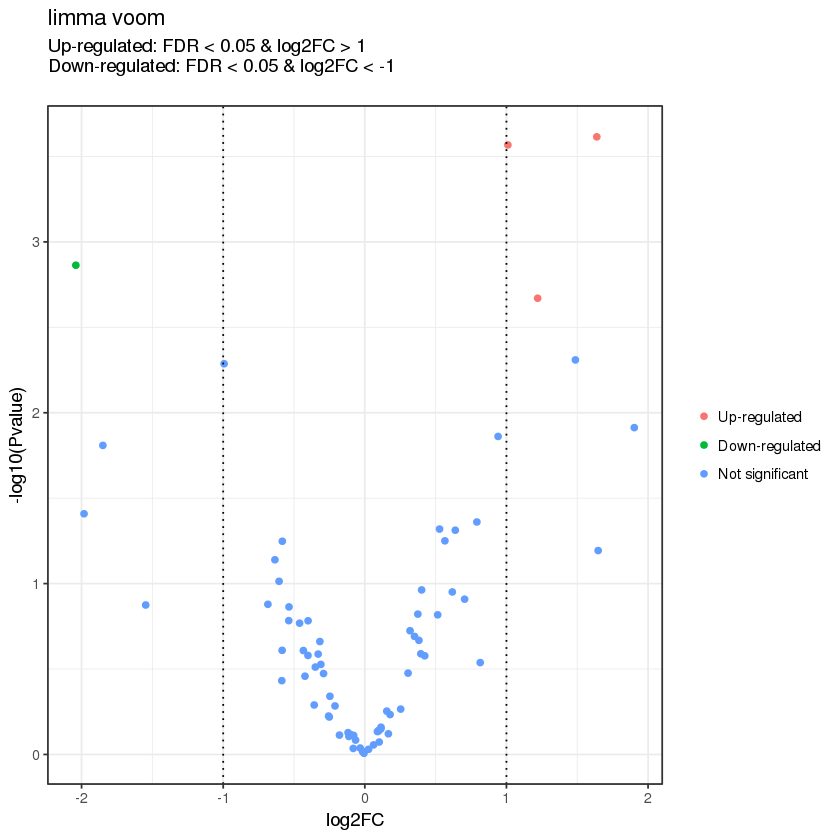

In [11]:
limma.res <- sce_qc$limma_pipeline(covs = covars)
head(limma.res)
sce_qc$volcanoPlot(FDR_threshold = 0.05, FC_threshold = 2, title = "limma voom")

Joining, by = "sample"
converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"  the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing
using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distribu

   user  system elapsed 
  1.305   0.000   1.305 


ID,baseMean,log2FC,lfcSE,Pvalue,FDR
ST6GALNAC3,36.56094,-1.8952645,0.6009887,6.240618e-05,0.004424915
SLC1A3,88.85171,1.2045522,0.3877532,1.195923e-04,0.004424915
ARHGAP24,98.41380,0.6961972,0.2383105,4.479084e-04,0.011048408
NAV3,70.19386,-1.0729044,0.4609727,9.802270e-04,0.018134199
MALAT1,1463.73596,0.9522605,0.4861607,2.859654e-03,0.042322874
DOCK4,150.75669,-0.6342605,0.3605048,7.892978e-03,0.097346728


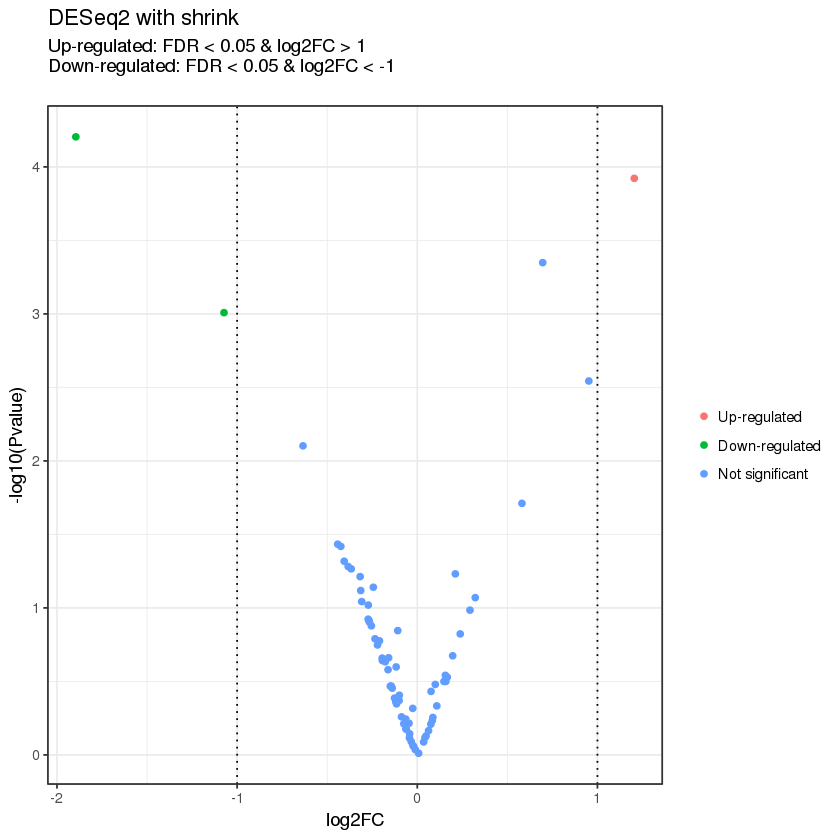

In [13]:
deseq2.shrink.res <- sce_qc$DESeq2_pipeline(covs = covars)
head(deseq2.shrink.res)
sce_qc$volcanoPlot(FDR_threshold = 0.05, FC_threshold = 2, title = "DESeq2 with shrink")

Performed DE analysis for 74 genes.
Model failed to converge for 0 (0%) genes!


ID,log2FC,Pvalue,Error,FDR
ST6GALNAC3,-2.425325,3.913479e-14,FALSE,2.661165e-12
NAV3,-1.631262,2.723303e-13,FALSE,9.259231e-12
SLC1A3,1.235525,4.734218e-10,FALSE,1.073089e-08
ANKRD44,-1.091572,1.091172e-07,FALSE,1.854993e-06
FOXN3,-1.002523,1.371022e-07,FALSE,1.864590e-06
ITPR2,-1.209787,1.437088e-06,FALSE,1.628700e-05


Warning message:
"Removed 6 rows containing missing values (geom_point)."

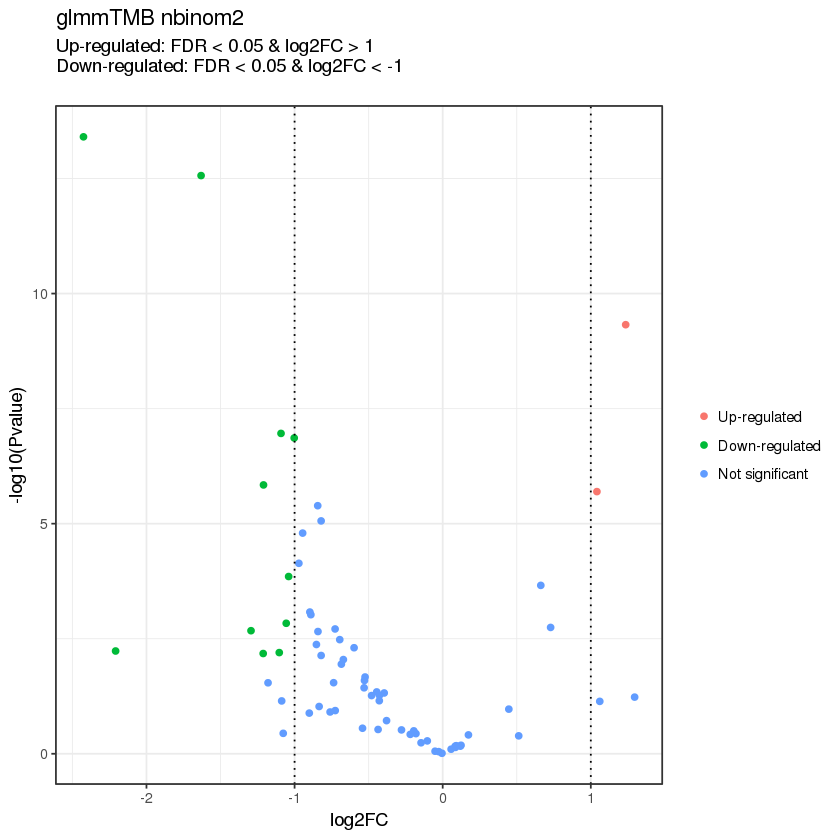

In [14]:
glmmTMB.res <- sce_qc$glmmTMB_pipeline(covs = covars, family = "nbinom2", detection_rate = FALSE)
head(glmmTMB.res)
sce_qc$volcanoPlot(FDR_threshold = 0.05, FC_threshold = 2, title = "glmmTMB nbinom2")

Warning message in .local(object, ...):
"using library sizes as size factors"`fData` has no primerid.  I'll make something up.
`cData` has no wellKey.  I'll make something up.
Assuming data assay in position 2, with name logcounts is log-transformed.
fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
Warning message in vcov.merMod(object@fitD):
"variance-covariance matrix computed from finite-difference Hessian is
not positive definite or contains NA values: falling back to var-cov estimated from RX"boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
Warning message in vcov.merMod(object@fitD):
"variance-covariance matrix computed from finite-diff

ID,Pvalue,log2FC,ci.hi,ci.lo,FDR
MALAT1,NA,NaN,NaN,NaN,NA
ANKRD44,1.851997e-06,-0.056192675,0.096143717,-0.208529066,0.0001351958
ARHGAP24,8.284211e-06,0.002136657,0.007805351,-0.003532037,0.0001614753
MBNL1,8.926726e-06,0.083571854,0.195356386,-0.028212678,0.0001614753
NAV3,9.704965e-06,NaN,NaN,NaN,0.0001614753
PICALM,1.105995e-05,0.011608173,0.057890123,-0.034673778,0.0001614753


Warning message:
"Removed 22 rows containing missing values (geom_point)."

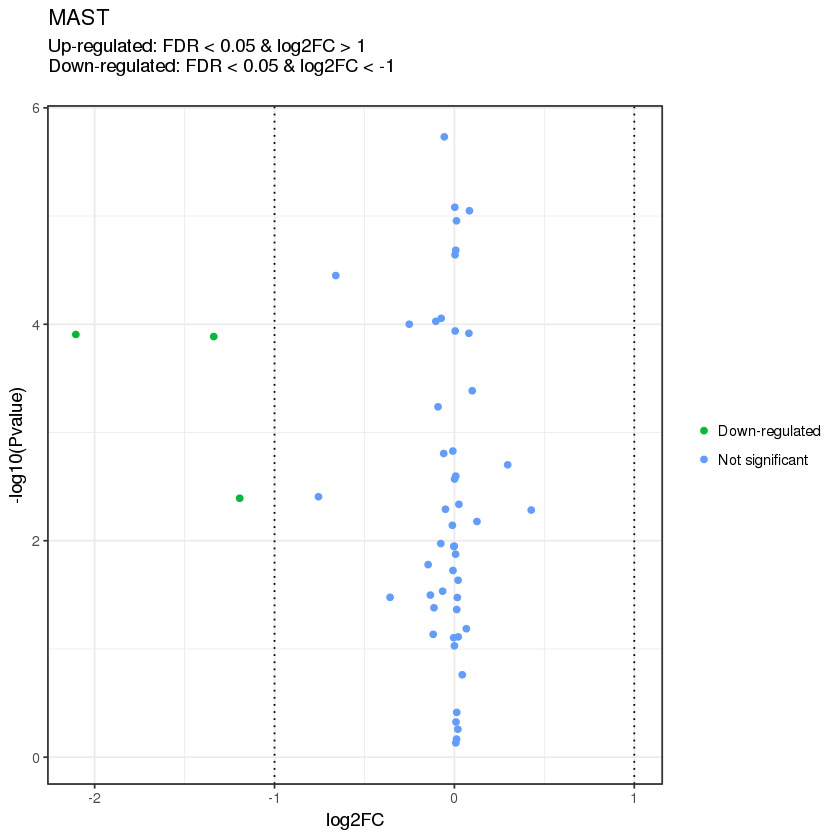

In [15]:
MAST.res <- sce_qc$MAST_pipeline(covs = covars, detection_rate = TRUE)
head(MAST.res)
sce_qc$volcanoPlot(FDR_threshold = 0.05, FC_threshold = 2, title = "MAST")

Forming DGEList...
Calculating NormFactors...
Creating design matrix...
    sampleC1 sampleC2 sampleC3 sampleC4 sampleC5 sampleC6 sampleC7 sampleMS1
55         1        0        0        0        0        0        0         0
80         1        0        0        0        0        0        0         0
85         1        0        0        0        0        0        0         0
104        1        0        0        0        0        0        0         0
108        1        0        0        0        0        0        0         0
163        1        0        0        0        0        0        0         0
    sampleMS10 sampleMS11 sampleMS12 sampleMS2 sampleMS3 sampleMS4 sampleMS5
55           0          0          0         0         0         0         0
80           0          0          0         0         0         0         0
85           0          0          0         0         0         0         0
104          0          0          0         0         0         0         0
108 

ID,log2FC,AveExpr,t,Pvalue,FDR,B
MALAT1,1.429866,17.80499,7.379476,2.610595e-13,1.931840e-11,19.5521083
SYNDIG1,-1.684968,12.43157,-5.064010,4.609282e-07,1.705434e-05,5.9559838
ST6GALNAC3,-1.575891,12.34393,-4.617710,4.208844e-06,1.038182e-04,3.8775548
NAV3,-1.481374,12.96059,-4.193170,2.910407e-05,5.384254e-04,2.0703953
SLC1A3,1.424493,14.00783,3.843913,1.261074e-04,1.866390e-03,0.7121721
SPP1,1.407442,14.15493,3.016094,2.603245e-03,3.210669e-02,-2.1179855


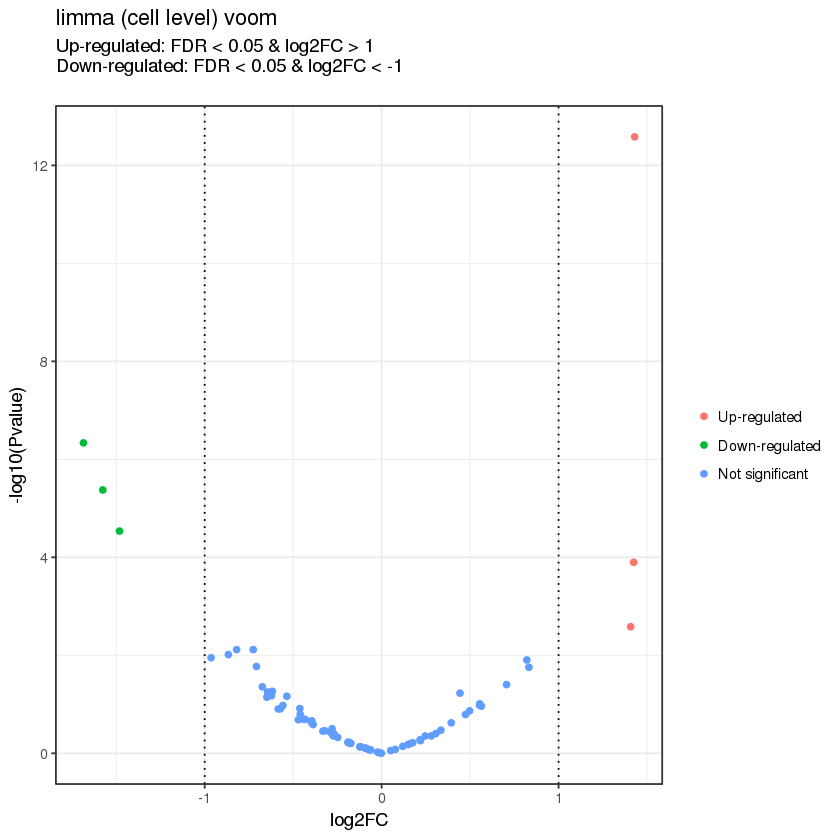

In [16]:
limma.cell.res <- sce_qc$limma_cell_level_pipeline(covs = covars)
head(limma.cell.res)
sce_qc$volcanoPlot(FDR_threshold = 0.05, FC_threshold = 2, title = "limma (cell level) voom")


Joining, by = "sample"


ID,log2FC,Pvalue,FDR
MALAT1,-1.0806769,0.008473044,0.3135026
NAV3,1.4883417,0.008408219,0.3135026
ST6GALNAC3,5.8900354,0.013560270,0.3344866
SLC8A1,0.6167038,0.050209316,0.3845471
SLC1A3,-1.0802934,0.027940303,0.3845471
ARHGAP26,-0.8570244,0.036546300,0.3845471


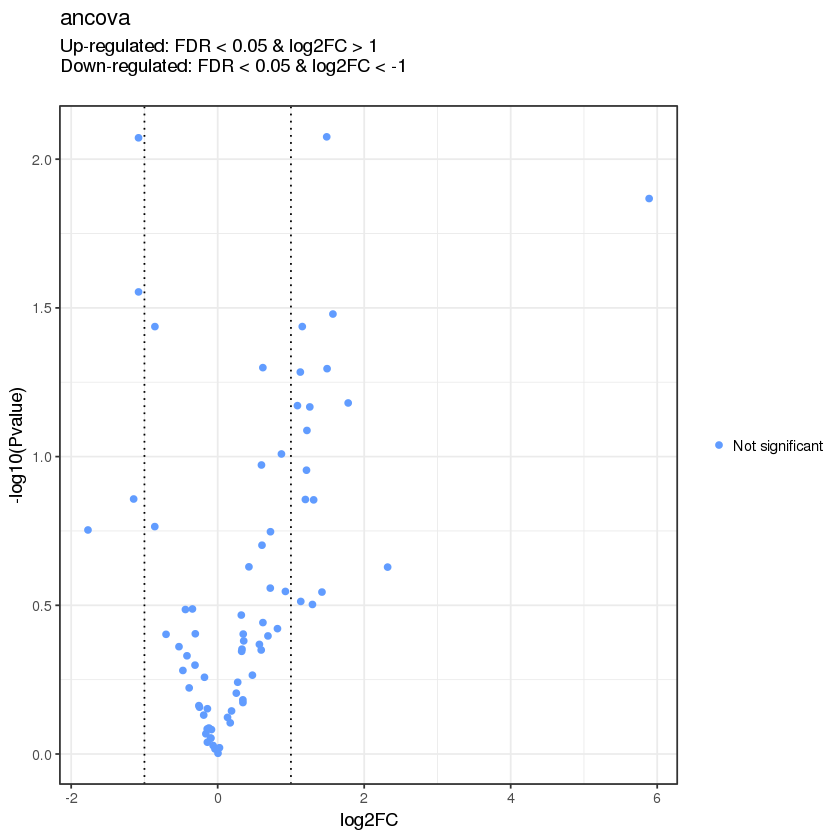

In [17]:
ancova.res <- sce_qc$ancova_pipeline(covs = covars)
head(ancova.res)
sce_qc$volcanoPlot(FDR_threshold = 0.05, FC_threshold = 2, title = "ancova")


Joining, by = "cell"


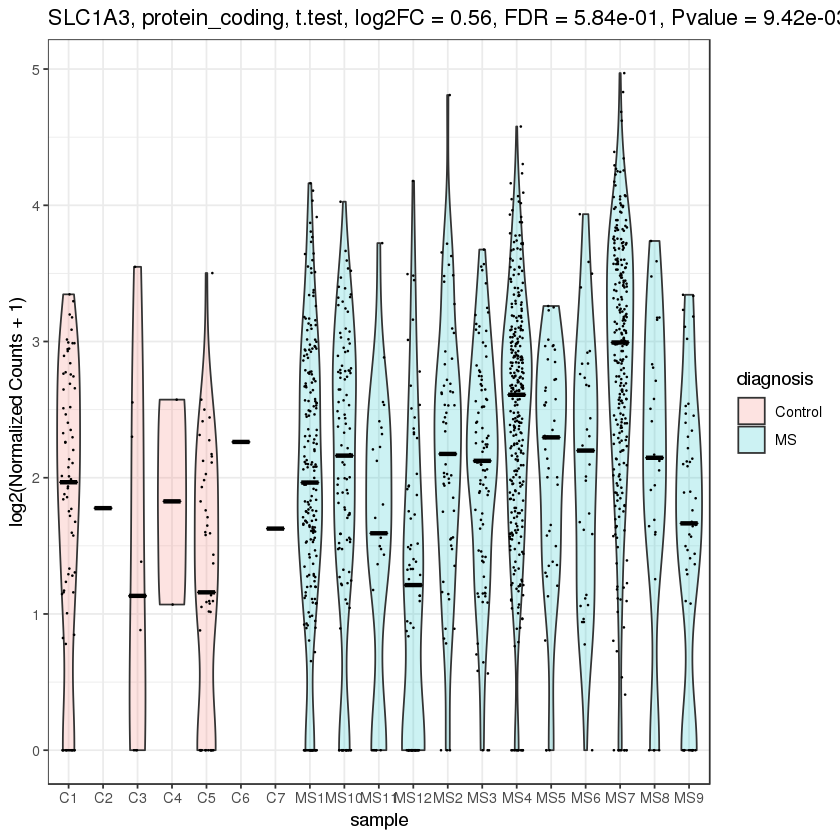

In [19]:
sce_qc$violinPlot(gene.name="SLC1A3",de.method="t.test",cellinfo="cell")